Читатель, прости, это слишком `1d`, оч много нужно для `2d` переписать

In [182]:
import numpy as np
import matplotlib.pyplot as plt

from IPython import display

Последнее достижение - 2d модель с одной жидкостью. Шаг вперёд, шаг назад. Теперь 1d с 2 жидкостями

Запишем некоторые свойства общие для резервуара

In [183]:
nx = 25
k = 1e-1 * 1.987e-13  # 1 darcy to m^2
dx = 1 # m
dy = 5 # m
phi = 0.4
p_0 = 4e4 * 6894  # psi to Pa
p = np.ones((nx, 1)) * p_0
d = 3  # m
dt = 3  # s
s_0 = 0.4
s_o = np.ones((nx, 1)) * s_0
s_w = np.ones((nx, 1))* (1 - s_0)

Перейдём к сжимаемости для [rock](https://www.sciencedirect.com/topics/engineering/formation-compressibility), [water and oil](http://www.fekete.com/san/webhelp/feketeharmony/harmony_webhelp/content/html_files/reference_material/general_concepts/reservoir_properties.htm)

In [184]:
c_w = 1e-6 # # Pa^-1
c_o = 1e-6 # # Pa^-1
c_r = 3e-6 #  Pa^-1 

Также различаются вязкости [oil](https://petrowiki.org/Oil_viscosity) и [water](http://fekete.com/SAN/TheoryAndEquations/HarmonyTheoryEquations/Content/HTML_Files/Reference_Material/General_Concepts/Reservoir_Fluid_Properties.htm)

In [185]:
B_o = 1
B_w = 1
mu_o = 1e2 / 1000 # cp to Pa * s
mu_w = 0.7 / 1000 # cp to Pa * s

Теперь напишем уравнение для одной фазы

Поток в скважину
$$q_{\alpha} = (p_{w} - p_{l}) \cdot \frac{4\pi k_{\alpha}}{B_{\alpha}\mu_{\alpha}} \cdot \frac{r_w r_{ref}}{r_w - r_{ref}}=\\
(p_{w} - p_{l}) \cdot J_l^{\alpha} k_{\alpha}
$$

Уравнение для резурвуара
$$\frac{\partial}{\partial x}\big(\frac{k k^{rel}_{\alpha} A_x}{\mu B_{\alpha}} \frac{\partial p}{\partial x}\big) \Delta x
+ q_{\alpha}
=\frac{V_b}{\alpha}\frac{\partial}{\partial t}\big(S_{\alpha}\frac{\phi}{B_{\alpha}}\big)
$$


$$\frac{\partial}{\partial t} \frac{\phi S_{\alpha}}{B_{\alpha}} = \frac{\phi}{B_{\alpha}} \frac{\partial S_{\alpha}}{\partial t} + \big( \frac{\phi S_{\alpha}}{B_{\alpha}} c_{\alpha}  + \frac{\phi S_{\alpha}}{B_{\alpha}} c_r \big) \frac{\partial p}{\partial t}$$

Домножим левую и правую части на $B_{\alpha}$

$$\frac{\partial}{\partial x}\big(\frac{k k^{rel}_{\alpha} A_x}{\mu} \frac{\partial p}{\partial x}\big) \Delta x
+ q_{\alpha} B_{\alpha}
= V_b\Big(
\phi \frac{\partial S_{\alpha}}{\partial t} + \phi \big(S_{\alpha} c_{\alpha}  + S_{\alpha} c_r \big) \frac{\partial p}{\partial t}
\Big)
$$

Сложим два этих уравнения для $\alpha$ нефть (o) и вода (w), учитывая что $S_w + S_o = 1$

$$\frac{\partial}{\partial x}\big(\big[\frac{k k^{rel}_{o} A_x}{\mu_o} + \frac{k k^{rel}_{w} A_x}{\mu_w}\big]
\frac{\partial p}{\partial x}\big) \Delta x
+ q_{o} B_{o} + q_{w} B_{w}
= V_b\Big(
0 +\phi \big(S_o c_o + S_w c_w  +1\cdot c_r \big) \frac{\partial p}{\partial t}
\Big)
$$

Добавим сюда расчёт значения расхода $q_{\alpha}$

$$\frac{\partial}{\partial x}\big(k A_x \big[\frac{k^{rel}_{o}}{\mu_o} + \frac{k^{rel}_{w}}{\mu_w}\big]
\frac{\partial p}{\partial x}\big) \Delta x + \\
(\vec{p}_{\texttt{well}} - \vec{p}) \cdot J_l^{o} k_{o} k_{o}^{rel} B_{o} + 
(\vec{p}_{\texttt{well}} - \vec{p}) \cdot J_l^{w} k_{w} k_{w}^{rel} B_{w} = \\
V_b\phi \Big(S_o c_o + S_w c_w  +c_r
\Big)\frac{\partial p}{\partial t}
$$

По сути тут опять нужно определить матрицу `lapl`, чтобы приблизить общий лапласиан с коэффициентами.
Все коэффициенты понятны, табличные величины, кроме $k_{\alpha}^{rel}$.
Все модели что я видел достаточно сложны, поэтому напишу быстренько функцию, похожую на то что есть на графиках

In [186]:
def k_rel_w(s):
    trh_b = 0.2
    trh_t = 0.6
    mult = 3
    out = 0
    if s < trh_b:
        out = 0
    elif s < trh_t:
        out = (s - trh_b) ** 2
    else:
        out = (trh_t - trh_b) ** 2
    return out * mult


def k_rel_o(s):
    trh_b = 0.2
    trh_t = 0.8
    mult = 2
    out = 0
    if s < trh_b:
        out = 0
    elif s < trh_t:
        out = (s - trh_b) ** 2
    else:
        out = (trh_t - trh_b) ** 2
    return out * mult

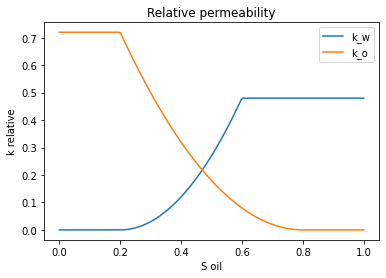

In [187]:
ss = np.linspace(0, 1, 200)
k_rels_w = [k_rel_w(s) for s in ss]
k_rels_o = [k_rel_o(1 - s) for s in ss]
plt.plot(ss, k_rels_w, label='k_w')
plt.plot(ss, k_rels_o, label='k_o')
plt.xlabel('S oil')
plt.ylabel("k relative")
plt.title('Relative permeability')
plt.legend()
plt.show()

В этой модели будем учитывать, что при перетекании жидкости из ячеек берётся $k^{\texttt{rel}^{\alpha}}(S\texttt{[i,j]})$ той ячейки, где больше давление.
Пока ограничимся равномерным распределением permeability.

In [188]:
class ResState:
    def __init__(self, values, bound_value):
        self.values = values
        self.bound_v = bound_value
        self.shape = values.shape
    def __getitem__(self, item):
        i, j = item
        if (i < 0) | (j < 0) | (i >= self.shape[0]) | (j >= self.shape[0]):
            return self.bound_v
        else:
            return self.values[i, j]

In [189]:
p = ResState(p, p_0)
s_o = ResState(s_o, s_0)
s_w = ResState(s_w, 1 - s_0)

In [190]:
def k_rel_o_p(i, j, s, p):
    if p[i, 0] > p[j, 0]:
        out =  k_rel_o(s[i, 0])
    else:
        out = k_rel_o(s[j, 0])
    return out


def k_rel_w_p(i, j, s, p):
    if p[i, 0] > p[j, 0]:
        out =  k_rel_w(s[i, 0])
    else:
        out = k_rel_w(s[j, 0])
    return out


def k_rel_ph(i, j, s, p, ph):
    out = 0       
        
    if ph == 'o':
        out = k_rel_o_p(i, j, s, p)
    elif ph == 'w':
        out = k_rel_w_p(i, j, s, p)
    return out

Ну что, быстренько заполним матрицу для расчёта лапласиана

$$A_x \Big(\frac{\big[\frac{k k^{rel}_{o}}{\mu_o} + \frac{k k^{rel}_{w}}{\mu_w}\big]_{i-\frac{1}{2}}}{\Delta x_{i-\frac{1}{2}}}p_{i-1}
- \big( \frac{\big[\frac{k k^{rel}_{o}}{\mu_o} + \frac{k k^{rel}_{w}}{\mu_w}\big]_{i+\frac{1}{2}}}
{\Delta x_{i+\frac{1}{2}}} + 
\frac{\big[\frac{k k^{rel}_{o}}{\mu_o} + \frac{k k^{rel}_{w}}{\mu_w}\big]_{i-\frac{1}{2}}}{\Delta x_{i-\frac{1}{2}}}\big)p_{i}
+\frac{\big[\frac{k k^{rel}_{o}}{\mu_o} + \frac{k k^{rel}_{w}}{\mu_w}\big]_{i+\frac{1}{2}}}{\Delta x_{i+\frac{1}{2}}}p_{i+1}\Big) + \\
+ (\vec{p}_{\texttt{well}} - \vec{p}) \cdot J^{o} k_{o} k_{o}^{rel} B_{o} + 
(\vec{p}_{\texttt{well}} - \vec{p}) \cdot J^{w} k_{w} k_{w}^{rel} B_{w}=\\
=\phi V_b \big(S_o c_o + S_w c_w  +1\cdot c_r \big) \frac{p^{n+1}_i - p^{n}_i}{\Delta t}
$$

В уравнении лапласиан можно представить как сумму двух, для воды и нефти.
Так и будем их реализовывать.

In [191]:
def get_lapl_one_ph(p, s, mu, k, d, dx, dy, ph):
    lapl = np.zeros((nx, nx))
    for dia in range(nx): 
        lapl[dia, dia] -= k * k_rel_ph(dia, dia-1, s, p, ph) / mu / dx
        lapl[dia, dia] -= k * k_rel_ph(dia, dia+1, s, p, ph) / mu / dx
        if dia-1 >= 0:
            lapl[dia, dia-1] += k * k_rel_ph(dia, dia-1, s, p, ph) / mu / dx
        if dia+1 < nx:
            lapl[dia, dia+1] += k * k_rel_ph(dia, dia+1, s, p, ph) / mu / dx
    lapl *= d * dy
    return lapl

In [192]:
lapl_w = get_lapl_one_ph(p, s_w, mu_w, k, d, dx, dy, 'w')
lapl_o = get_lapl_one_ph(p, s_o, mu_o, k, d, dx, dy, 'o')

Также нужны граничные условия для этого лапласиана

In [193]:
def get_q_bound(p, s, ph, mu):
    out = np.zeros((nx, 1))
    out[0][0] += k * k_rel_ph(0, -1, s, p, ph) / mu / dx * p[-1, 0]
    out[nx-1][0] += k * k_rel_ph(nx-1, nx, s, p, ph) / mu / dx * p[nx, 0]
    out *= d * dy 
    return out

In [194]:
q_bound_w = get_q_bound(p, s_w, 'w', mu_w)
q_bound_o = get_q_bound(p, s_o, 'o', mu_o)

Так, ещё уделим внимание получению расхода
$$
q = 
(\vec{p}_{\texttt{well}} - \vec{p}) \cdot J^{o} k_{o} k_{o}^{rel} + 
(\vec{p}_{\texttt{well}} - \vec{p}) \cdot J^{w} k_{w} k_{w}^{rel} = \\
=  - \big(J^{o} k_{o} k_{o}^{rel} +  J^{w} k_{w} k_{w}^{rel}\big) \vec{p}  + \\
+ \big(J^{o} k_{o} k_{o}^{rel} +  J^{w} k_{w} k_{w}^{rel}\big) \vec{p}_{\texttt{well}} = \\
- \big( J_w(S_w) + J_o(S_o)\big) \vec{p} + \big( J_w(S_w) + J_o(S_o)\big) \vec{p}_{\texttt{well}}
$$

$$
J_{\alpha}\big(S_{\alpha}\big) = \frac{4\pi k_{\alpha}}{B_{\alpha} \mu_{\alpha}} \frac{r_{\texttt{ref}}r_{\texttt{well}}}{r_{\texttt{ref}}+r_{\texttt{well}}} \cdot k_{\alpha}^{\texttt{rel}}
$$


$$
r_{ref} = \frac{1}{\frac{1}{\Delta x} + \frac{\pi}{d}}$$

In [195]:
r_ref = 1 / (1 / dx + np.pi / d)

In [196]:
def get_j_matrix(p, s, mu, k, B, pos_r, r_ref, ph):
    out = np.zeros((nx, 1))
    for pos in pos_r:
        out[pos] = 4 * np.pi * k / B / mu
        out[pos] *= r_ref * pos_r[pos]
        out[pos] /= (r_ref + pos_r[pos])
        out[pos] *= k_rel_ph(i=pos[0], j=pos[0], s=s, p=p, ph=ph)
    return out

In [197]:
pos_r = {(12, 0): 0.05, (22, 0): 0.05}
p_well = np.zeros((nx, 1))
p_w = p_0 - 25 * 6894.
for pos in pos_r:
    p_well[pos] = p_w

In [198]:
j_o = get_j_matrix(p=p, s=s_o, mu=mu_o, k=k, B=B_o, pos_r=pos_r, r_ref=r_ref, ph='o')
j_w = get_j_matrix(p=p, s=s_w, mu=mu_w, k=k, B=B_w, pos_r=pos_r, r_ref=r_ref, ph='w')

И последний штрих - перед производной по времени есть $V_b\big(S_o c_o + S_w c_w  +1\cdot c_r\big)$. Назовём это `dt_comp_sat`

In [199]:
dt_comp_sat = dx * dy * d *(s_o.values * c_o + s_w.values * c_w + np.ones((nx, 1)) * c_r)

Похоже на то что можно писать основной цикл для процесса

$$J^{\alpha} k_{\alpha} k_{\alpha}^{rel} = \tilde{J}^{\alpha}$$
\
\
$$
L \vec{p}^{n} - \big(\tilde{J}^{o}B_{o} +  \tilde{J}^{w}B_{w}\big) \vec{p}^{n}
+ \vec{q}_{\texttt{bound}}^{w} + \vec{q}_{\texttt{bound}}^{o} 
+ \big(J^{o} +  J^{w}\big) \vec{p}_{\texttt{well}} = \\
= \phi \cdot \texttt{dt_comp_sat} \cdot \frac{\vec{p}^{n+1}_i - \vec{p}^{n}_i}{\Delta t}
$$

$$
\big[
\phi \cdot \texttt{dt_comp_sat}\cdot I - L \cdot dt + \big(\tilde{J}^{o}B_{o} +  \tilde{J}^{w}B_{w}\big) \cdot dt
\big] \vec{p}^{n+1} =\\
= \phi \cdot \texttt{dt_comp_sat}\cdot \vec{p}^{n} + \vec{q}_{\texttt{bound}}^{w} + \vec{q}_{\texttt{bound}}^{o} +
+ \big(J^{o} +  J^{w}\big) \vec{p}_{\texttt{well}}
$$

А вот так обновляется насыщение
$$\frac{\partial}{\partial x}\big(\frac{k k^{rel}_{\alpha} A_x}{\mu} \frac{\partial p}{\partial x}\big) \Delta x
+ q_{\alpha} B_{\alpha}
= V_b\Big(
\phi \frac{\partial S_{\alpha}}{\partial t} + \phi \big(S_{\alpha} c_{\alpha}  + S_{\alpha} c_r \big) \frac{\partial p}{\partial t}
\Big)
$$

$$
L_o \vec{p^{n+1}} + \vec{q}_{\texttt{bound}}^{o} + \tilde{J}^{o}B_{o} \vec{p}_{\texttt{well}}
- \tilde{J}^{o}B_{o}\vec{p}^{n+1} = V_b \phi \frac{\vec{S}_{\alpha}^{n+1} - \vec{S}_{\alpha}^{n}}{dt} + \phi V_b 
\big(\vec{S}_{\alpha}^{n+1} c_{\alpha}  + \vec{S}_{\alpha}^{n+1} c_r \big) \frac{\vec{p}^{n+1}- \vec{p}^n}{dt}
$$

$$
V_b \phi \big[I + \big(c_{\alpha} + c_r\big) \cdot \big(\vec{p}^{n+1}- \vec{p}^n\big)\big] \vec{S}_{\alpha}^{n+1} =\\
= V_b\phi \vec{S}_{\alpha}^{n} + \big(L_o \vec{p^{n+1}} + \vec{q}_{\texttt{bound}}^{o} +
\tilde{J}^{o}B_{o} \vec{p}_{\texttt{well}}
- \tilde{J}^{o}B_{o}\vec{p}^{n+1}\big) dt
$$

$$
V_b \phi\vec{S}_{\alpha}^{n+1}=\\
= V_b\phi \vec{S}_{\alpha}^{n} - V_b \phi \big(c_{\alpha} + c_r\big) \cdot \big(\vec{p}^{n+1}- \vec{p}^n\big) \vec{S}_{\alpha}^{n}
+ \big(L_o \vec{p^{n+1}} + \vec{q}_{\texttt{bound}}^{o} +
\tilde{J}^{o}B_{o} \vec{p}_{\texttt{well}}
- \tilde{J}^{o}B_{o}\vec{p}^{n+1}\big) dt
$$

In [200]:
n_iter = int(2e6)
p_ex = np.ones((nx, 1)) * p_0
t = 0
xs = list((np.linspace(0, nx-1, nx) + dx/2) * dx)
plot_freq = int(0.3e4)
times = []
p_well_hist = {}
s_o_well_hist = {}
q_o_hist = {}
q_w_hist = {}
for w in pos_r:
    p_well_hist[w] = []
    s_o_well_hist[w] = []
    q_o_hist[w] = []
    q_w_hist[w] = []

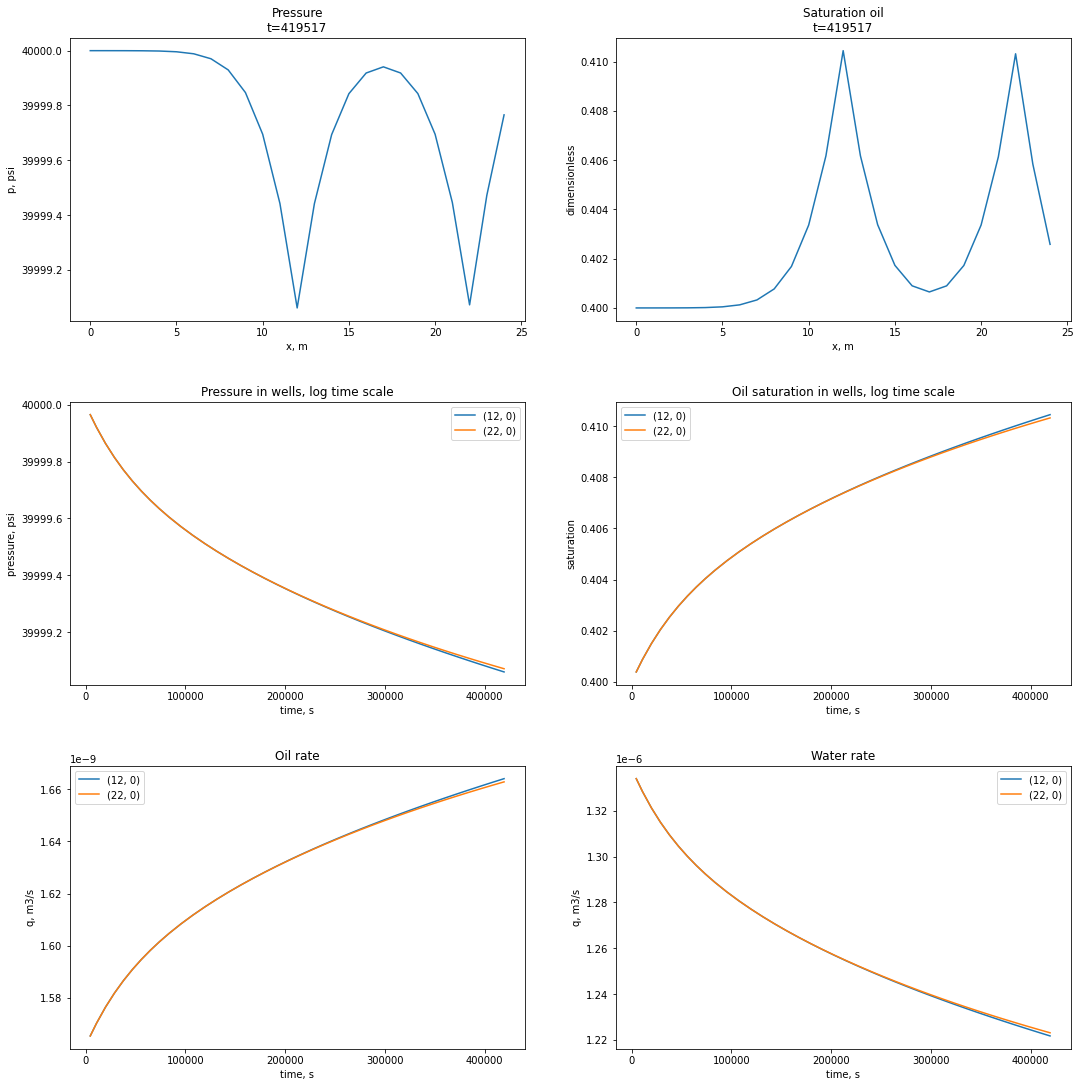

In [ ]:
for i in range(1, n_iter):
    # gonna increase time step
    if t < 60 * 24 * 1: # a day
        dt = 1
    elif 60 * 24 < t < 60 * 24 * 7: # a week
        dt = 2
    elif 60 * 24 * 7 < t < 60 * 24 * 7 * 4 * 2: # 2 month
        dt = 3
    elif 60 * 24 * 7 * 4 * 2 < t < 60 * 24 * 365: # more then 2 month
        dt = 4
    # matrixes depends on saturation
    dt_comp_sat = dx * dy * d *(s_o.values * c_o + s_w.values * c_w + np.ones((nx, 1)) * c_r)
    j_o = get_j_matrix(p=p, s=s_o, mu=mu_o, k=k, B=B_o, pos_r=pos_r, r_ref=r_ref, ph='o')
    j_w = get_j_matrix(p=p, s=s_w, mu=mu_w, k=k, B=B_w, pos_r=pos_r, r_ref=r_ref, ph='w')
    lapl_w = get_lapl_one_ph(p, s_w, mu_w, k, d, dx, dy, 'w')
    lapl_o = get_lapl_one_ph(p, s_o, mu_o, k, d, dx, dy, 'o')
    q_bound_w = get_q_bound(p, s_w, 'w', mu_w)
    q_bound_o = get_q_bound(p, s_o, 'o', mu_o)
    # matrix for implicit pressure
    a = phi * np.eye(nx) * dt_comp_sat - (lapl_w+lapl_o) * dt + np.diag((j_o * B_o + j_w * B_w).reshape(-1)) * dt
    #right hand state for ax = b
    b = phi * dt_comp_sat * p.values + q_bound_w*dt + q_bound_o*dt + (j_o * B_o + j_w * B_w) * p_well * dt
    # upd time stamp
    t += dt
    # solve p
    p_new = np.linalg.solve(a, b)
    # upd oil saturation
    # a matrix for implicit stuff
    # a = dx*dy*d * phi *( np.ones((nx, 1)) + (c_r + c_w) * (p_new - p.values))
    # b = phi * dx*dy*d * s_w.values + dt * (lapl_w.dot(p_new) + q_bound_w + j_w * B_w * (p_well - p_new))
    # upd sat wat
    # s_w = ResState(b / a, 1 - s_0) 
    # s_o
    a = dx*dy*d * phi *( np.ones((nx, 1)) + (c_r + c_o) * (p_new - p.values))
    b = phi * dx*dy*d * s_o.values + dt * (lapl_o.dot(p_new) + q_bound_o + j_o * B_o * (p_well - p_new))
    # upd sat wat
    s_o = ResState(b / a, s_0) 
    s_w = ResState(np.ones((nx, 1)) - s_o.values, 1 - s_0) 
    
    
    dp = p_new - p.values
    p = ResState(p_new, p_0)
    if i % plot_freq == 0:
        
        q_o = (-1) * j_o * (p_well - p.values)
        q_w = (-1) * j_w * (p_well - p.values)
        
        times.append(t)
        for w in pos_r:
            p_well_hist[w].append(p[w] / 6894.)
            s_o_well_hist[w].append(s_o[w])
            q_o_hist[w].append(q_o[w])
            q_w_hist[w].append(q_w[w])
        display.clear_output(wait=True)
        f, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))
        f.tight_layout(pad=6.0)
        ax[0][0].plot(p.values / 6894.)
        ax[0][0].set_title(f'Pressure\nt={t}')
        ax[0][0].set_ylabel(f'p, psi')
        ax[0][0].set_xlabel(f'x, m')
        
        ax[0][1].plot(s_o.values)
        ax[0][1].set_title(f'Saturation oil\nt={t}')
        ax[0][1].set_ylabel(f'dimensionless')
        ax[0][1].set_xlabel(f'x, m')
        
        for w in pos_r:
            ax[1][0].plot(times, p_well_hist[w] , label=f'{w}')
            ax[1][1].plot(times, s_o_well_hist[w] , label=f'{w}')
            ax[2][0].plot(times, q_o_hist[w] , label=f'{w}')
            ax[2][1].plot(times, q_w_hist[w] , label=f'{w}')
        ax[1][0].set_xlabel('time, s')
        ax[1][0].set_ylabel('pressure, psi')
        ax[1][0].set_title('Pressure in wells, log time scale')
        ax[1][0].legend()
        
        ax[1][1].set_xlabel('time, s')
        ax[1][1].set_ylabel('saturation')
        ax[1][1].set_title('Oil saturation in wells, log time scale')
        ax[1][1].legend()
        
        
        ax[2][0].set_xlabel('time, s')
        ax[2][0].set_ylabel('q, m3/s')
        ax[2][0].set_title('Oil rate')
        ax[2][0].legend()
        
        ax[2][1].set_xlabel('time, s')
        ax[2][1].set_ylabel('q, m3/s')
        ax[2][1].set_title('Water rate')
        ax[2][1].legend()
        #ax[1][0].set_xscale('log')
        #ax[2][0].set_xscale('log')
        
    
        
        ax[0][1].ticklabel_format(useOffset=False, axis='y')
        ax[1][1].ticklabel_format(useOffset=False, axis='y')
        ax[0][0].ticklabel_format(useOffset=False, axis='y')
        ax[1][0].ticklabel_format(useOffset=False, axis='y')
        ax[2][0].ticklabel_format(useOffset=False, axis='y')
        plt.show()